# Sergio Lopez 02/08/2019

In [1]:
import pandas as pd
import json
import itertools
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, CuDNNLSTM, CuDNNGRU, Dropout, Conv1D, Activation, SpatialDropout1D,\
                            MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Embedding, CuDNNLSTM, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras import optimizers
from keras import backend as K
from matplotlib import pyplot as plt
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
# check GPU is available
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
full_data = pd.read_csv("../dataset/movies_metadata.csv")

C:\Users\oro_s\Anaconda3\envs\env0\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = full_data.loc[:, ["title", "genres", "overview"]]

In [5]:
data.head()

,title,genres,overview
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...


# Define targets

In [6]:
# cast genre col to python objects
genres_col = list(data["genres"].apply(lambda x: [q["name"] for q in eval(x)]).values)
# flatten into a single list
genre_occurances = list(itertools.chain.from_iterable(genres_col))
genres = set(genre_occurances)
# keep genres that appear more than 1 time
common_genres_counts = {g: genre_occurances.count(g) for g in genres if genre_occurances.count(g) > 1}
common_genres = list(common_genres_counts.keys())
common_genres_counts

{'Foreign': 1622,
 'History': 1398,
 'Western': 1042,
 'Documentary': 3932,
 'Adventure': 3496,
 'Fantasy': 2313,
 'Animation': 1935,
 'War': 1323,
 'Horror': 4673,
 'Music': 1598,
 'Action': 6596,
 'Mystery': 2467,
 'Drama': 20265,
 'Science Fiction': 3049,
 'Crime': 4307,
 'Romance': 6735,
 'Thriller': 7624,
 'Comedy': 13182,
 'TV Movie': 767,
 'Family': 2770}

In [7]:
sorted_common_genres_counts = sorted(common_genres_counts.items(), key=lambda kv: kv[1], reverse=True)
ngenres = 10
used_genres = list(zip(*(sorted_common_genres_counts[:ngenres])))[0]
used_genres

('Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Horror',
 'Crime',
 'Documentary',
 'Adventure',
 'Science Fiction')

In [8]:
# now let us create the targets by removing non used genres
data["targets"] = [[g for g in l if g in used_genres] for l in genres_col]
# drop genres column
data = data.drop("genres", axis=1)

print("{} movies left".format(len(data)))

45466 movies left


In [9]:
data.head()

,title,overview,targets
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",[Comedy]
1,Jumanji,When siblings Judy and Peter discover an encha...,[Adventure]
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Romance, Comedy]"
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,[Comedy]


In [10]:
# # remove movies with more than one genre
# data = data[data['targets'].map(lambda d: len(d)) == 1]
# # unpack genre now that there is a single one
# data["targets"] = data["targets"].apply(lambda x: x[0])

# ------------------------------------------------------------

def splitDataFrameList(df,target_column):
    def splitListToRows(row,row_accumulator,target_column):
        for s in row[target_column]:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column))
    new_df = pd.DataFrame(new_rows)
    return new_df

data = splitDataFrameList(data, "targets")

print("{} movies left".format(len(data)))

73859 movies left


In [11]:
data.head()

,overview,targets,title
0,"Led by Woody, Andy's toys live happily in his ...",Comedy,Toy Story
1,When siblings Judy and Peter discover an encha...,Adventure,Jumanji
2,A family wedding reignites the ancient feud be...,Romance,Grumpier Old Men
3,A family wedding reignites the ancient feud be...,Comedy,Grumpier Old Men
4,"Cheated on, mistreated and stepped on, the wom...",Comedy,Waiting to Exhale


# filter out non valid samples and resample for balance


In [12]:
# drop movies with some non defined value
data = data.dropna(axis=0)
print("{} movies left".format(len(data)))

72959 movies left


In [13]:
# drop movies with "not found" plot
data = data[data['overview'] != "No overview found."]
print("{} movies left".format(len(data)))

72798 movies left


In [14]:
# check imbalance in dataset
used_genres_counts = {g: list(data["targets"].values).count(g) for g in list(used_genres)}
used_genres_counts

{'Drama': 19979,
 'Comedy': 12745,
 'Thriller': 7570,
 'Romance': 6667,
 'Action': 6552,
 'Horror': 4647,
 'Crime': 4265,
 'Documentary': 3883,
 'Adventure': 3469,
 'Science Fiction': 3021}

In [15]:
# subsample dataset to balance it out
nsamples = 20000

def subsample_frame(df, column, nsamples):
    r = []
    for c in used_genres:
        c_samples = df.loc[df[column] == c, :]
        # c_choices = c_samples.sample(nsamples, axis=0, replace=True)
        if used_genres_counts[c] > nsamples:
            c_choices = c_samples.iloc[:nsamples, :]
        else:
            print("NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE {}".format(c))
            c_choices = pd.concat([c_samples, c_samples.sample(nsamples - used_genres_counts[c], replace=True)])
        r.append(c_choices)

    return pd.concat(r, ignore_index=True).sample(frac=1).reset_index(drop=True)


baldata = subsample_frame(data, "targets", nsamples)
# baldata = data
len(baldata)

NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Drama
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Comedy
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Thriller
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Romance
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Action
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Horror
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Crime
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Documentary
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Adventure
NOT ENOUGH SAMPLES! RESAMPLING FOR GENRE Science Fiction


200000

In [16]:
# check imbalance in dataset AGAIN AFTER RESAMPLING
{g: list(baldata["targets"].values).count(g) for g in list(used_genres)}

{'Drama': 20000,
 'Comedy': 20000,
 'Thriller': 20000,
 'Romance': 20000,
 'Action': 20000,
 'Horror': 20000,
 'Crime': 20000,
 'Documentary': 20000,
 'Adventure': 20000,
 'Science Fiction': 20000}

# Refine input text

In [17]:
# tokenize plots
from nltk import word_tokenize
baldata["overview"] = baldata["overview"].apply(lambda x: word_tokenize(x))

baldata.head()

,overview,targets,title
0,"[A, policeman, is, assigned, by, his, superior...",Science Fiction,Into Pitch Black
1,"[A, youth, potion, transforms, an, old, crone,...",Science Fiction,Satanik
2,"[Umekichi, ,, a, geisha, in, the, Gion, distri...",Drama,Sisters of the Gion
3,"[A, young, man, finds, out, that, he, holds, t...",Adventure,Titan A.E.
4,"[Crown, Prince, Rudolf, of, Austria, (, Omar, ...",Romance,Mayerling


In [18]:
# remove proper nouns
# from nltk.tag import pos_tag
# baldata["overview"] = baldata["overview"].apply(lambda x: [w for w,p in pos_tag(x) if p != 'NNP' and p!= 'NNPS'])

# baldata.head()

In [19]:
# remove stop words and punctuation and set all words to lower case
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from stop_words import get_stop_words

# stop = stopwords.words('english') + list(string.punctuation)
stop = list(get_stop_words('en'))  + list(string.punctuation)
baldata["overview"] = baldata["overview"].apply(lambda x: [w.lower() for w in x if w not in stop])

# make sure no punctuation symbols remain in any word
def strip_punctuaction(s):
    for x in string.punctuation:
        s = s.replace(x, "")
    return s
baldata["overview"] = baldata["overview"].apply(lambda x: [strip_punctuaction(w)  for w in x if w not in stop and  w != ""])


baldata.head()




,overview,targets,title
0,"[policeman, assigned, superior, officer, find,...",Science Fiction,Into Pitch Black
1,"[youth, potion, transforms, old, crone, ravish...",Science Fiction,Satanik
2,"[umekichi, geisha, gion, district, kyoto, feel...",Drama,Sisters of the Gion
3,"[young, man, finds, holds, key, restoring, hop...",Adventure,Titan A.E.
4,"[crown, prince, rudolf, austria, omar, sharif,...",Romance,Mayerling


In [20]:
# put together words into a single string
baldata["overview"] = baldata["overview"].apply(lambda x: " ".join(x))

baldata.head()

,overview,targets,title
0,policeman assigned superior officer find appre...,Science Fiction,Into Pitch Black
1,youth potion transforms old crone ravishing be...,Science Fiction,Satanik
2,umekichi geisha gion district kyoto feels obli...,Drama,Sisters of the Gion
3,young man finds holds key restoring hope ensur...,Adventure,Titan A.E.
4,crown prince rudolf austria omar sharif clashe...,Romance,Mayerling


In [21]:
# put together one hot targets
onehot_encoder = MultiLabelBinarizer()
onehot_encoder.fit([{x} for x in used_genres])
y_train = onehot_encoder.transform([{x} for x in baldata["targets"]])

print(onehot_encoder.classes_)
print(y_train.shape)
print(y_train[:10, :])

['Action' 'Adventure' 'Comedy' 'Crime' 'Documentary' 'Drama' 'Horror'
 'Romance' 'Science Fiction' 'Thriller']
(200000, 10)
[[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


# tokenize movie plots into fixed size nummeric sequences

In [22]:
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# extract input training data
x_train = baldata["overview"].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
# map words to numbers
x_train_tokens = tokenizer.texts_to_sequences(x_train)
# pad sequences
max_length = max([len(x) for x in x_train])
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')

In [23]:
print(vocab_size)
print(max_length)
print(x_train_pad.shape)
print(len(used_genres))
print(vocab_size)

81595
925
(200000, 925)
10
81595


# Training our model

In [29]:

# train model using vector representations of length 200
EMBEDDING_DIM = 64

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D())
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(len(used_genres), activation = "softmax")) #, kernel_regularizer=l2(0.01)))

model.compile(loss="categorical_crossentropy",
              optimizer = optimizers.Adam(lr=0.00005), # 00005
              metrics=["accuracy"])

history = model.fit(x_train_pad, y_train, batch_size=128, epochs=40, validation_split=0.2, shuffle=True, verbose=True)

Train on 160000 samples, validate on 40000 samples
Epoch 1/40
160000/160000 [==============================] - 52s 326us/step - loss: 2.3023 - acc: 0.1026 - val_loss: 2.3013 - val_acc: 0.1230
Epoch 2/40
160000/160000 [==============================] - 51s 320us/step - loss: 2.2707 - acc: 0.1325 - val_loss: 2.1510 - val_acc: 0.2351
Epoch 3/40
160000/160000 [==============================] - 51s 320us/step - loss: 1.9865 - acc: 0.2667 - val_loss: 1.8677 - val_acc: 0.3691
Epoch 4/40
160000/160000 [==============================] - 51s 320us/step - loss: 1.7594 - acc: 0.3586 - val_loss: 1.7111 - val_acc: 0.4297
Epoch 5/40
160000/160000 [==============================] - 51s 320us/step - loss: 1.6261 - acc: 0.4138 - val_loss: 1.6157 - val_acc: 0.4615
Epoch 6/40
160000/160000 [==============================] - 51s 321us/step - loss: 1.5399 - acc: 0.4452 - val_loss: 1.5620 - val_acc: 0.4777
Epoch 7/40
160000/160000 [==============================] - 51s 320us/step - loss: 1.4715 - acc: 0.4699

Text(0.5, 1.0, 'Accuracy')

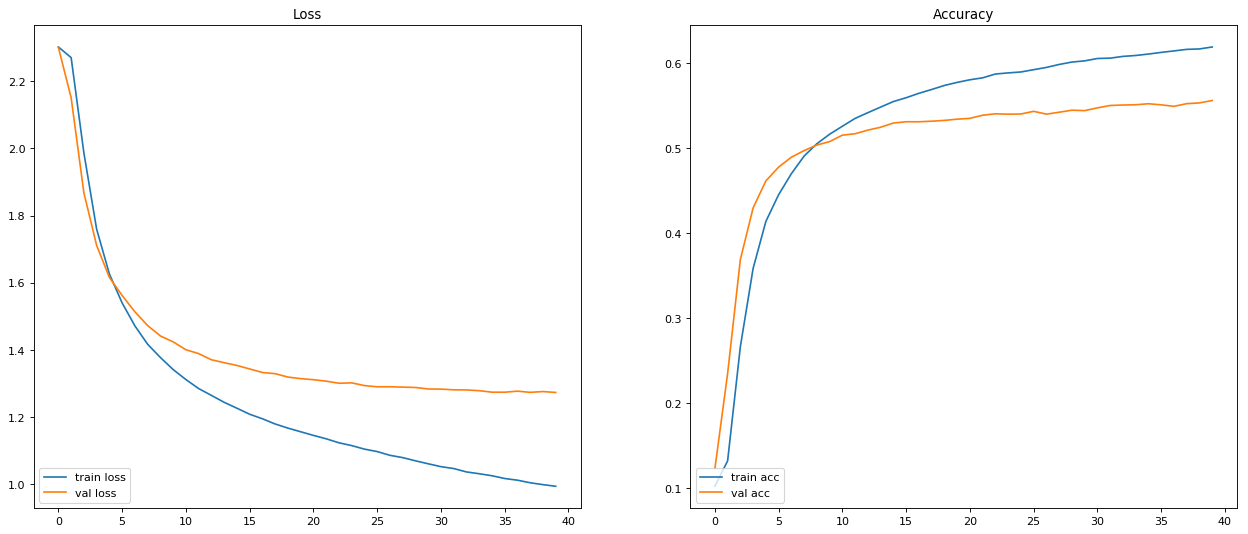

In [30]:
fig=plt.figure(figsize=(30, 8), dpi= 80, facecolor='w', edgecolor='k')

histories = [history]

plt.subplot(1,3,1, )
plt.plot(list(itertools.chain.from_iterable([x.history['loss'] for x in histories])))
plt.plot(list(itertools.chain.from_iterable([x.history['val_loss'] for x in histories])))
plt.legend(['train loss', 'val loss', 'train acc', 'val acc', 'auroc', 'auroc val'], loc='lower left')
plt.title("Loss")

plt.subplot(1,3,2)
plt.plot(list(itertools.chain.from_iterable([x.history['acc'] for x in histories])))
plt.plot(list(itertools.chain.from_iterable([x.history['val_acc'] for x in histories])))
plt.legend(['train acc', 'val acc', ], loc='lower left')
plt.title("Accuracy")

# Testing on made up movies

In [32]:
title = "The endless war"
# description = "The Avengers and their allies must be willing to sacrifice all in an attempt to defeat the powerful Thanos before his blitz of devastation and ruin puts an end to the universe."
description = "cesar attacks the nazi germany and destroys everyone in his path"
# tokenize
input_string = word_tokenize(description)
# remove proper names
# input_string = [w for w,p in pos_tag(input_string) if p != 'NNP']
# remove stop words
input_string = [w.lower() for w in input_string if w not in stop]
# put together in a single string
input_string = " ".join(input_string)


dense_input = pad_sequences(tokenizer.texts_to_sequences([input_string]), maxlen=max_length, padding='post')
pred = model.predict(dense_input)

for i, p in enumerate(np.squeeze(pred).tolist()):
    print("{0}: {1} \n".format(used_genres[i], p))
    

Drama: 0.10991725325584412 

Comedy: 0.12171925604343414 

Thriller: 0.0875123143196106 

Romance: 0.11768709123134613 

Action: 0.05882999300956726 

Horror: 0.08865319192409515 

Crime: 0.10999249666929245 

Documentary: 0.10122369229793549 

Adventure: 0.09532798081636429 

Science Fiction: 0.1091366857290268 



In [33]:
# save model
model.save("../model/model.h5")
# save keras tokenizer
tokenizer_json = tokenizer.to_json()
with open('../model/keras_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
# save extra nummeric parameters to disk in a dictionary
params = {'max_length': max_length, "used_genres": used_genres}
with open('../model/parameters.pickle', 'wb') as h:
    pickle.dump(params, h, protocol=pickle.HIGHEST_PROTOCOL)

